In [67]:
%pip install -U langchain langchain-core langchain-google-genai langchain-community langgraph python-dotenv 

Note: you may need to restart the kernel to use updated packages.


In [68]:
from langchain_google_genai import GoogleGenerativeAI
from dotenv import load_dotenv
import os

# --- 환경 설정 ---
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

if not GOOGLE_API_KEY:
    raise ValueError("환경 변수 'GOOGLE_API_KEY'를 설정해주세요. (.env 파일 확인)")
model = GoogleGenerativeAI(model="gemini-2.5-flash")
model.invoke("안녕하세요!")

'안녕하세요!'

In [69]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict을 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
        'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]

graph_builder = StateGraph(State)

In [70]:
from langchain_core.tools import tool
from datetime import datetime
import pytz

# --- [수정] .env 및 Tavily API 키 로드를 위한 import ---
from dotenv import load_dotenv
import os
from langchain_community.tools.tavily_search import TavilySearchResults

import bs4
from langchain_community.document_loaders import WebBaseLoader

# --- [추가] .env 파일에서 API 키 로드 ---
load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")

if not tavily_api_key:
    print("경고: .env 파일에 TAVILY_API_KEY가 설정되지 않았습니다.")
# ------------------------------------


# 도구 함수 정의
@tool
def get_current_time(timezone: str, location: str) -> str:
    """현재 시각을 반환하는 함수."""
    try:
        tz = pytz.timezone(timezone)
        now = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
        result = f'{timezone} ({location}) 현재시각 {now}'
        # print(result)
        return result
    except pytz.UnknownTimeZoneError:
        return f"알 수 없는 타임존: {timezone}"
    

# --- [수정] get_web_search 함수를 Tavily 버전으로 교체 ---
@tool
def get_web_search(query: str) -> str:
    """
    Tavily를 사용하여 웹 검색을 수행하는 함수.
    'search_period' 인자는 받지 않습니다.
    
    Args:
        query (str): 검색어

    Returns:
        str: 검색 결과 (Snippet, Title, URL 형식)
    """
    print('\n-------- TAVILY WEB SEARCH --------')
    print(f'Query: {query}')

    # Tavily 검색 도구 초기화 (k=5: 5개의 결과 요청)
    search = TavilySearchResults(
        k=5, 
        tavily_api_key=tavily_api_key # API 키 명시적 전달
    ) 
    
    try:
        # Tavily는 [ {'url': ..., 'content': ...}, ... ] 형식의 딕셔너리 리스트를 반환
        docs = search.invoke(query)
        
        results_str_list = []
        
        # (원본 코드의 print 루프 동작을 유지)
        print("Search Results:")
        for i, doc in enumerate(docs):
            snippet = doc.get('content', '내용 없음')
            title = doc.get('title', '제목 없음')
            url = doc.get('url', '출처 없음')
            
            # (참고 코드의 반환 형식)
            formatted_result = f"Snippet: {snippet}\nTitle: {title}\nURL: {url}"
            results_str_list.append(formatted_result)
            
            # (원본 코드의 print 동작)
            print(f"--- Result {i+1} ---")
            print(formatted_result)

        # (참고 코드의 반환 방식)
        return "\n\n;\n\n".join(results_str_list)

    except Exception as e:
        print(f"Tavily 검색 오류: {e}")
        return f"검색 중 오류가 발생했습니다: {e}"


# 도구 바인딩 (변경 없음)
tools = [get_current_time, get_web_search]

In [71]:
tools[0].invoke({"timezone": "Asia/Seoul", "location":"서울"})

'Asia/Seoul (서울) 현재시각 2025-11-19 10:50:15'

In [72]:
tools[1].invoke({"query": "전지적 독자 시점 영화"})


-------- TAVILY WEB SEARCH --------
Query: 전지적 독자 시점 영화
Search Results:
--- Result 1 ---
Snippet: 오프닝 개봉전부터 말도 탈도 참 많았던 전지적 독자 시점이 드디어 개봉했습니다. 제 8,612 행성계의 무료 서비스가 종료되었습니다. 이거 그 소설 시작이랑 못지. 저도 개봉찬을 바로 보고 왔거든요. 일단 저는 소설 웹툰을 보지 않았기 때문에 원작을 전혀 모르는 사람입니다. 그런 사람 입장에서이 전독씨가 어땠는지 내가 좋아했던 나의 전부였던 이야기가 현실이 되었다. 그리고 저는이 영화가 한국 영화 블록버스트의 무덤이라고 생각하거든요. 왜 그렇게 생각하는지 하나하나 그려보도록 하겠습니다. 나는 내 동료들과 함께이 이야기의 결말을 새로 쓰겠다. 간단한 줄거리 소개 일단 영화의 줄거리를 간단하게 이야기해 볼게요. 이야기의 시점은 평범한 일상소 평범하게 지내는 김독자의 시점으로 시작됩니다.이 독자는 평범한 대학을 나와서 평범한 회사의 계약직이에요. 그런데 이날은 김독자에게 조금 특별했습니다. 바로 어린 시절부터 봤던 소설의 결말이 나왔고 그 결말에 불만을 가지고 항이 메이를 보내고 [...] 우연히 나오면 다시 봐도 무방한 그런 작품. 패스는 다시 볼 가치가 없는 그런 작품이다. 자 그럼 전지적 독자 시점의 점수는 배점은 5점만점 1점. 다시 보기 지수 무료입니다. 종합적으로 배우들의 연기 CG 액션 세계관 뭐 하나 크게 장점으로 보이는게 없었습니다. 한국 영화 인식도 안 좋고 관객을 모으기도 쉽지 않은 지금 시대에서 원작 고증도 하지 못하고 작품성도 좋지 못했다는 건 솔직히 보지 말라고 시위하는 느낌이기도 해요. 그럼에도 나중에 TV나 VOD로 나온다면 한 번쯤은 다시 볼 수도 있겠죠. 오늘 이야기를들은 여러분들은 전독시를 어떻게 보셨는지 자유롭게 댓글로 의견 남겨 주세요. 그리고 며칠 전에 업로드한 한국 영화관에 관한 영상도 재미있으니까 꼭 한번 보시길 추천해 드리면서 저는 여기서 인사드릴

'Snippet: 오프닝 개봉전부터 말도 탈도 참 많았던 전지적 독자 시점이 드디어 개봉했습니다. 제 8,612 행성계의 무료 서비스가 종료되었습니다. 이거 그 소설 시작이랑 못지. 저도 개봉찬을 바로 보고 왔거든요. 일단 저는 소설 웹툰을 보지 않았기 때문에 원작을 전혀 모르는 사람입니다. 그런 사람 입장에서이 전독씨가 어땠는지 내가 좋아했던 나의 전부였던 이야기가 현실이 되었다. 그리고 저는이 영화가 한국 영화 블록버스트의 무덤이라고 생각하거든요. 왜 그렇게 생각하는지 하나하나 그려보도록 하겠습니다. 나는 내 동료들과 함께이 이야기의 결말을 새로 쓰겠다. 간단한 줄거리 소개 일단 영화의 줄거리를 간단하게 이야기해 볼게요. 이야기의 시점은 평범한 일상소 평범하게 지내는 김독자의 시점으로 시작됩니다.이 독자는 평범한 대학을 나와서 평범한 회사의 계약직이에요. 그런데 이날은 김독자에게 조금 특별했습니다. 바로 어린 시절부터 봤던 소설의 결말이 나왔고 그 결말에 불만을 가지고 항이 메이를 보내고 [...] 우연히 나오면 다시 봐도 무방한 그런 작품. 패스는 다시 볼 가치가 없는 그런 작품이다. 자 그럼 전지적 독자 시점의 점수는 배점은 5점만점 1점. 다시 보기 지수 무료입니다. 종합적으로 배우들의 연기 CG 액션 세계관 뭐 하나 크게 장점으로 보이는게 없었습니다. 한국 영화 인식도 안 좋고 관객을 모으기도 쉽지 않은 지금 시대에서 원작 고증도 하지 못하고 작품성도 좋지 못했다는 건 솔직히 보지 말라고 시위하는 느낌이기도 해요. 그럼에도 나중에 TV나 VOD로 나온다면 한 번쯤은 다시 볼 수도 있겠죠. 오늘 이야기를들은 여러분들은 전독시를 어떻게 보셨는지 자유롭게 댓글로 의견 남겨 주세요. 그리고 며칠 전에 업로드한 한국 영화관에 관한 영상도 재미있으니까 꼭 한번 보시길 추천해 드리면서 저는 여기서 인사드릴게요. 구독과 알림 설정 눌러 주시면 앞으로도 각종 영화 소개로 계속 인사드리겠습니다. 지금까지 필링 그린의 박그린이었습니다. 감사합니다. 모두가 죽고 혼자 살

In [73]:
tools[1].invoke({"query": "전지적 독자 시점 영화"})


-------- TAVILY WEB SEARCH --------
Query: 전지적 독자 시점 영화
Search Results:
--- Result 1 ---
Snippet: 오프닝 개봉전부터 말도 탈도 참 많았던 전지적 독자 시점이 드디어 개봉했습니다. 제 8,612 행성계의 무료 서비스가 종료되었습니다. 이거 그 소설 시작이랑 못지. 저도 개봉찬을 바로 보고 왔거든요. 일단 저는 소설 웹툰을 보지 않았기 때문에 원작을 전혀 모르는 사람입니다. 그런 사람 입장에서이 전독씨가 어땠는지 내가 좋아했던 나의 전부였던 이야기가 현실이 되었다. 그리고 저는이 영화가 한국 영화 블록버스트의 무덤이라고 생각하거든요. 왜 그렇게 생각하는지 하나하나 그려보도록 하겠습니다. 나는 내 동료들과 함께이 이야기의 결말을 새로 쓰겠다. 간단한 줄거리 소개 일단 영화의 줄거리를 간단하게 이야기해 볼게요. 이야기의 시점은 평범한 일상소 평범하게 지내는 김독자의 시점으로 시작됩니다.이 독자는 평범한 대학을 나와서 평범한 회사의 계약직이에요. 그런데 이날은 김독자에게 조금 특별했습니다. 바로 어린 시절부터 봤던 소설의 결말이 나왔고 그 결말에 불만을 가지고 항이 메이를 보내고 [...] 우연히 나오면 다시 봐도 무방한 그런 작품. 패스는 다시 볼 가치가 없는 그런 작품이다. 자 그럼 전지적 독자 시점의 점수는 배점은 5점만점 1점. 다시 보기 지수 무료입니다. 종합적으로 배우들의 연기 CG 액션 세계관 뭐 하나 크게 장점으로 보이는게 없었습니다. 한국 영화 인식도 안 좋고 관객을 모으기도 쉽지 않은 지금 시대에서 원작 고증도 하지 못하고 작품성도 좋지 못했다는 건 솔직히 보지 말라고 시위하는 느낌이기도 해요. 그럼에도 나중에 TV나 VOD로 나온다면 한 번쯤은 다시 볼 수도 있겠죠. 오늘 이야기를들은 여러분들은 전독시를 어떻게 보셨는지 자유롭게 댓글로 의견 남겨 주세요. 그리고 며칠 전에 업로드한 한국 영화관에 관한 영상도 재미있으니까 꼭 한번 보시길 추천해 드리면서 저는 여기서 인사드릴

'Snippet: 오프닝 개봉전부터 말도 탈도 참 많았던 전지적 독자 시점이 드디어 개봉했습니다. 제 8,612 행성계의 무료 서비스가 종료되었습니다. 이거 그 소설 시작이랑 못지. 저도 개봉찬을 바로 보고 왔거든요. 일단 저는 소설 웹툰을 보지 않았기 때문에 원작을 전혀 모르는 사람입니다. 그런 사람 입장에서이 전독씨가 어땠는지 내가 좋아했던 나의 전부였던 이야기가 현실이 되었다. 그리고 저는이 영화가 한국 영화 블록버스트의 무덤이라고 생각하거든요. 왜 그렇게 생각하는지 하나하나 그려보도록 하겠습니다. 나는 내 동료들과 함께이 이야기의 결말을 새로 쓰겠다. 간단한 줄거리 소개 일단 영화의 줄거리를 간단하게 이야기해 볼게요. 이야기의 시점은 평범한 일상소 평범하게 지내는 김독자의 시점으로 시작됩니다.이 독자는 평범한 대학을 나와서 평범한 회사의 계약직이에요. 그런데 이날은 김독자에게 조금 특별했습니다. 바로 어린 시절부터 봤던 소설의 결말이 나왔고 그 결말에 불만을 가지고 항이 메이를 보내고 [...] 우연히 나오면 다시 봐도 무방한 그런 작품. 패스는 다시 볼 가치가 없는 그런 작품이다. 자 그럼 전지적 독자 시점의 점수는 배점은 5점만점 1점. 다시 보기 지수 무료입니다. 종합적으로 배우들의 연기 CG 액션 세계관 뭐 하나 크게 장점으로 보이는게 없었습니다. 한국 영화 인식도 안 좋고 관객을 모으기도 쉽지 않은 지금 시대에서 원작 고증도 하지 못하고 작품성도 좋지 못했다는 건 솔직히 보지 말라고 시위하는 느낌이기도 해요. 그럼에도 나중에 TV나 VOD로 나온다면 한 번쯤은 다시 볼 수도 있겠죠. 오늘 이야기를들은 여러분들은 전독시를 어떻게 보셨는지 자유롭게 댓글로 의견 남겨 주세요. 그리고 며칠 전에 업로드한 한국 영화관에 관한 영상도 재미있으니까 꼭 한번 보시길 추천해 드리면서 저는 여기서 인사드릴게요. 구독과 알림 설정 눌러 주시면 앞으로도 각종 영화 소개로 계속 인사드리겠습니다. 지금까지 필링 그린의 박그린이었습니다. 감사합니다. 모두가 죽고 혼자 살

In [74]:
for tool in tools:
    print(tool.name, tool)

get_current_time name='get_current_time' description='현재 시각을 반환하는 함수.' args_schema=<class 'langchain_core.utils.pydantic.get_current_time'> func=<function get_current_time at 0x000002E21D86E520>
get_web_search name='get_web_search' description="Tavily를 사용하여 웹 검색을 수행하는 함수.\n'search_period' 인자는 받지 않습니다.\n\nArgs:\n    query (str): 검색어\n\nReturns:\n    str: 검색 결과 (Snippet, Title, URL 형식)" args_schema=<class 'langchain_core.utils.pydantic.get_web_search'> func=<function get_web_search at 0x000002E21D86ECA0>


In [75]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
import os
from langchain_community.tools.tavily_search import TavilySearchResults

# --- 환경 설정 ---
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

if not GOOGLE_API_KEY:
    raise ValueError("환경 변수 'GOOGLE_API_KEY'를 설정해주세요. (.env 파일 확인)")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=GOOGLE_API_KEY,
)

In [76]:
for tool in tools:
    print(tool.name, tool)

get_current_time name='get_current_time' description='현재 시각을 반환하는 함수.' args_schema=<class 'langchain_core.utils.pydantic.get_current_time'> func=<function get_current_time at 0x000002E21D86E520>
get_web_search name='get_web_search' description="Tavily를 사용하여 웹 검색을 수행하는 함수.\n'search_period' 인자는 받지 않습니다.\n\nArgs:\n    query (str): 검색어\n\nReturns:\n    str: 검색 결과 (Snippet, Title, URL 형식)" args_schema=<class 'langchain_core.utils.pydantic.get_web_search'> func=<function get_web_search at 0x000002E21D86ECA0>


In [77]:
model_with_tools=llm.bind_tools(tools) #gemini는 chatGoogleGenerativeAI를 llm으로 받음

def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.
    
    매개변수:
    state (State): 현재 대화 상태를 나태는 객체로, 이전 메시지들이 포함되어 있습니다.

    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리
          형식은 {"messages": [응답 메시지]}입니다.
    """

    return {"messages": model_with_tools.invoke(state["messages"])}

graph_builder.add_node("generate", generate)

In [78]:
# 1. json 라이브러리를 가져옵니다. 
#    Python 객체(예: 딕셔너리, 리스트)를 JSON 문자열로 변환(dumps)하기 위해 사용됩니다.
import json

# 2. LangChain 라이브러리에서 'ToolMessage' 클래스를 가져옵니다.
#    ToolMessage는 AI 모델에게 '이것이 도구를 실행한 결과다'라고 알려주기 위한 표준 형식의 메시지 객체입니다.
from langchain_core.messages import ToolMessage

# 3. 'BasicToolNode'라는 이름의 클래스를 정의합니다.
#    이 클래스는 LangGraph에서 '노드(node)' 역할을 하도록 설계되었습니다.
#    주요 기능: AI가 요청한 도구(tool)를 실제로 실행하고 그 결과를 반환합니다.
class BasicToolNode:
    """
    도구를 실행하는 노드 클래스입니다. 마지막 AIMessage에서 요청된 도구를 실행합니다.
    (This is a node class that executes tools. It runs the tools requested in the last AIMessage.)
    """

    # 4. 클래스의 생성자(initializer) 메서드입니다.
    #    BasicToolNode 객체가 처음 생성될 때 (예: BasicToolNode(tools=...)) 호출됩니다.
    #    'tools': 이 노드가 사용할 수 있는 도구 객체들의 리스트(list)를 받습니다.
    def __init__(self, tools: list) -> None:
        
        # 5. 'tools_by_name'이라는 딕셔너리(dictionary)를 만들어 인스턴스 변수로 저장합니다.
        #    이 딕셔너리는 도구의 '이름(name)'을 키(key)로, 도구 객체(tool) 자체를 값(value)으로 가집니다.
        #    예: tools = [search_tool] -> self.tools_by_name = {"search": search_tool}
        #    이렇게 하면 나중에 도구 이름(문자열)만으로 해당 도구 객체를 빠르게 찾아 실행할 수 있습니다.
        self.tools_by_name = {tool.name: tool for tool in tools}

    # 6. 이 클래스의 객체를 함수처럼 호출할 수 있게 만드는 특별 메서드(__call__)입니다.
    #    LangGraph가 이 노드를 실행할 때 이 메서드가 호출됩니다. (예: tool_node(inputs))
    #    'inputs': 이 노드로 들어오는 데이터를 담은 딕셔너리입니다.
    #    이 딕셔너리 안에 "messages"라는 키로 전체 대화 기록(메시지 리스트)이 들어올 것으로 예상합니다.
    def __call__(self, inputs: dict):
        
        # 7. 'inputs' 딕셔너리에서 "messages" 키에 해당하는 값을 가져옵니다.
        #    - .get("messages", []): "messages" 키가 있으면 그 값을 가져오고, 
        #      만약 키가 없으면(예: 그래프 시작 시점) 기본값으로 빈 리스트([])를 반환합니다.
        #    - if messages := ... (Walrus 연산자): 
        #      가져온 값을 'messages' 변수에 할당함과 동시에, 그 값이 비어있지 않은지(True인지) 검사합니다.
        if messages := inputs.get("messages",[]):
            # 8. 'messages' 리스트가 비어있지 않다면(즉, 메시지가 하나라도 있다면),
            #    리스트의 가장 마지막 메시지(messages[-1])를 'message' 변수에 할당합니다.
            #    (가정: 이 마지막 메시지는 AI가 방금 생성한, 도구 사용 요청(tool_calls)이 담긴 AIMessage입니다.)
            message = messages[-1]
        else:
            # 9. 만약 'inputs'에 "messages" 키가 없거나 빈 리스트가 전달되었다면,
            #    이 노드는 실행할 도구 요청을 찾을 수 없으므로 'ValueError'를 발생시켜 문제를 알립니다.
            raise ValueError("No message found in input")
        
        # 10. 실행된 도구들의 결과를 담을 빈 리스트 'outputs'를 준비합니다.
        #     여기에는 'ToolMessage' 객체들이 추가될 것입니다.
        outputs = []

        # 11. 마지막 메시지('message')에 포함된 'tool_calls' 리스트를 순회(loop)합니다.
        #     'message.tool_calls'는 AI가 요청한 도구 호출 목록입니다. (하나의 메시지에 여러 개일 수 있음)
        #     'tool_call'은 개별 도구 호출 정보를 담은 딕셔너리입니다. 
        #     (예: {'name': 'search', 'args': {'query': '...'}, 'id': 'call_abc123'})
        for tool_call in message.tool_calls:
            
            # 12. 'tool_call' 딕셔너리에서 도구 이름(예: "search")을 가져옵니다.
            #     이 이름을 키로 사용하여 'self.tools_by_name' 딕셔너리에서 실행할 실제 도구 객체(예: search_tool)를 찾습니다.
            # 13. 찾은 도구 객체의 'invoke' 메서드를 호출하여 도구를 실행합니다.
            #     이때, 'tool_call' 딕셔너리의 "args" (도구에 전달할 인자)를 함께 넘겨줍니다.
            # 14. 도구 실행이 완료되면, 그 반환값을 'tool_result' 변수에 저장합니다.
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            
            # 15. 도구 실행 결과를 'outputs' 리스트에 추가합니다.
            outputs.append(
                # 16. 'ToolMessage' 객체를 생성하여 추가합니다.
                ToolMessage(
                    # 17. 'content': 도구 실행 결과('tool_result')를 JSON 문자열로 변환하여 저장합니다.
                    #     (결과가 딕셔너리나 숫자 등이어도, 모델은 문자열 형태의 입력을 기대하므로 json.dumps를 사용합니다.)
                    content=json.dumps(tool_result),
                    
                    # 18. 'name': 어떤 도구가 실행되었는지 그 이름을 명시합니다. (예: "search")
                    name=tool_call["name"],
                    
                    # 19. 'tool_call_id': AI가 처음에 요청했던 'tool_call'의 고유 ID(예: "call_abc123")를 그대로 전달합니다.
                    #     (이 ID가 있어야 AI가 "아, 내가 요청했던 그 작업의 결과구나"라고 정확히 인식할 수 있습니다.)
                    tool_call_id=tool_call["id"]
                )
            )
            
        # 20. 모든 도구 실행이 끝나면, 'inputs'로 받았던 기존 'messages' 리스트에
        #     방금 생성한 도구 결과 리스트('outputs')를 더(+)합니다.
        # 21. 이렇게 '기존 대화' + '새로운 도구 결과'가 합쳐진 전체 메시지 리스트를 
        #     "messages"라는 키에 담아 딕셔너리 형태로 반환합니다.
        # 22. 이 반환값은 LangGraph의 다음 노드(아마도 다시 AI 모델 노드)의 입력으로 전달됩니다.
        return {"messages": messages + outputs}

# --- 아래는 이 클래스를 사용하는 예시 코드입니다 ---

# 23. 위에서 정의한 'BasicToolNode' 클래스의 인스턴스(객체)를 생성합니다.
#     (가정: 'tools'라는 변수에는 [search_tool, calculator_tool] 처럼 실제 도구 객체 리스트가 이미 정의되어 있어야 합니다.)
#     생성자(__init__)가 호출되며, tool_node 인스턴스 내부에 'self.tools_by_name' 딕셔너리가 생성됩니다.
tool_node = BasicToolNode(tools=tools)

# 24. LangGraph의 'graph_builder' 객체(StateGraph의 인스턴스)에 노드를 추가합니다.
# 25. "tools"라는 이름(문자열)으로 'tool_node' 객체를 그래프에 등록합니다.
#     이제 그래프 워크플로우에서 "tools"라는 이름의 노드를 호출하면,
#     위에서 정의한 'tool_node.__call__' 메서드가 실행됩니다.
graph_builder.add_node("tools", tool_node)

In [79]:
def route_tools(state: State):
    """
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하고,
    그렇지 않은 경우 끝ㅇ느로 라우팅하기 위해 conditional_edge에서 사용합니다.
     """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages :=state.get("messages",[]):
        ai_message = messages[-1]
    else:
        raise ValueError(f"tool_edge 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls)>0:
        return "tools"
    return END

graph_builder.add_edge(START, "generate")

graph_builder.add_conditional_edges("generate", route_tools,{"tools": "tools", END: END},)

graph_builder.add_edge("tools", "generate")
graph = graph_builder.compile()

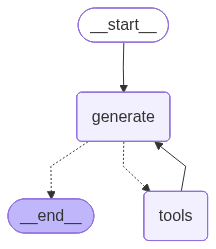

In [83]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [84]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="지금 서울 몇 시야?")]

# gathered를 리스트로 초기화하여 모든 메시지를 저장합니다.
gathered_history = [] 

for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    # 텍스트 스트리밍은 여전히 AIMessageChunk에서만 출력합니다.
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')
    
    # 모든 메시지 객체를 리스트에 추가합니다.
    gathered_history.append(msg)

# 최종 전체 메시지 이력 확인
gathered_history

서울은 2025년 11월 19일 10시 51분 29초입니다.

[AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'get_current_time', 'arguments': '{"timezone": "Asia/Seoul", "location": "\\uc11c\\uc6b8"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--8c829363-98e5-4c12-b89a-7433425ec978', tool_calls=[{'name': 'get_current_time', 'args': {'timezone': 'Asia/Seoul', 'location': '서울'}, 'id': '44c57b3a-7964-4fc9-8a4f-81fd822e3bb4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 159, 'total_tokens': 309, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 135}}, tool_call_chunks=[{'name': 'get_current_time', 'args': '{"timezone": "Asia/Seoul", "location": "\\uc11c\\uc6b8"}', 'id': '44c57b3a-7964-4fc9-8a4f-81fd822e3bb4', 'index': None, 'type': 'tool_call_chunk'}]),
 AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='lc_run--8c829363-98e5-4c12-b89a-7

In [85]:
from langchain_core.messages import AIMessageChunk, SystemMessage

about = "대한민국 핵잠수함 건조"

inputs = [SystemMessage(content=f"""
너는 신문기자이다.
최근 {about}에 대해 비판하는 심층 분석 기사를 쓰려고 한다
- 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘.
- 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐.
-검색할 리스트를 토대로 재검색해.
-목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해.
-검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋아.

더이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성한다.
제목, 부제, 리드문, 본문의 구성으로 작성한다. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이 있게 작성해야 한다.
""")]

for msg, metadata in graph.stream({"messages": inputs}, stream_mode= "messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')

ValueError: No content messages found. The Gemini API requires at least one non-system message (HumanMessage, AIMessage, etc.) in addition to any SystemMessage. Please include additional messages in your input.

In [90]:
# ---------------------------------------------------------
# Gemini + LangGraph 스트리밍 기사 생성 에이전트 (완전 작동)
# ---------------------------------------------------------

from __future__ import annotations
from typing import List, TypedDict, Annotated

import os
from dotenv import load_dotenv

from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessageChunk,
    BaseMessage,
)
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages


# ---------------------------------------------------------
# 0) 환경변수 로딩
# ---------------------------------------------------------
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")


# ---------------------------------------------------------
# 1) Gemini 모델 정의
# ---------------------------------------------------------
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_version="v1",
    google_api_key=GOOGLE_API_KEY,
    streaming=True,          # 스트리밍 활성화
)

model_with_tools = model     # (필요시 bind_tools 사용)


# ---------------------------------------------------------
# 2) LangGraph State 타입 정의
# ---------------------------------------------------------
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]  # add_messages 리듀서 사용


# ---------------------------------------------------------
# 3) generate 노드: LLM 한 번 호출 → 메시지 이어붙임
# ---------------------------------------------------------
def generate(state: State):
    response = model_with_tools.invoke(state["messages"])

    # add_messages 리듀서 적용을 위해 리스트로 감싸 반환
    return {"messages": [response]}


# ---------------------------------------------------------
# 4) 그래프 구성
# ---------------------------------------------------------
graph_builder = StateGraph(State)
graph_builder.add_node("generate", generate)
graph_builder.set_entry_point("generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()


# ---------------------------------------------------------
# 5) 실제 기사 생성 입력 메시지 구성
# ---------------------------------------------------------
# 5. 오류 수정된 입력 메시지
about = "대한민국 핵잠수함 건조 트럼프 대통령 승인"

# 🛑 오류 수정 부분: SystemMessage 뒤에 HumanMessage를 추가합니다.
inputs = [
    SystemMessage(content=f"""
너는 신문기자이다.
최근 {about}에 대해 비판하는 심층 분석 기사를 쓰려고 한다
- 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘.
- 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐.
-검색할 리스트를 토대로 재검색해.
-목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해.
-검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋아.

더이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성한다.
제목, 부제, 리드문, 본문의 구성으로 작성한다. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이 있게 작성해야 한다.
"""),
    HumanMessage(content="기사 작성을 시작하세요.")
]

# 6. 스트리밍 실행 (원본 코드의 실행 부분)
print(f"--- 🤖 Gemini 에이전트 시작: {about} ---")
for msg, metadata in graph.stream({"messages": inputs}, stream_mode= "messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='', flush=True)

print("\n" + "="*60)

Unexpected argument 'api_version' provided to ChatGoogleGenerativeAI. Did you mean: 'output_version'?


--- 🤖 Gemini 에이전트 시작: 대한민국 핵잠수함 건조 트럼프 대통령 승인 ---
## 대한민국 핵잠수함 건조, '트럼프發 승인론' 그 숨겨진 위험과 국제적 파장

### 1. 최근 이슈 선정 및 선정 이유

**최근 이슈:** 트럼프 전 대통령의 재집권 가능성이 점쳐지는 가운데, 그의 임기 중 논의되었던 대한민국 핵잠수함 건조 '승인론'이 다시금 수면 위로 떠오르고 있습니다. 이는 윤석열 정부의 한미 동맹 강화 기조와 맞물려 전략적 자산 확보의 필요성이 제기되는 한편, 핵확산금지조약(NPT) 체제 위협, 동북아 군비 경쟁 격화, 막대한 경제적 부담 등 다양한 비판적 시각을 동시에 불러일으키고 있습니다.

**선정 이유:**
1.  **높은 국민적 관심:** 핵잠수함은 국가 안보와 직결되는 최첨단 전략 무기로, 그 건조 여부는 항상 국민적 이목을 집중시킵니다. 특히 '핵'이라는 단어가 주는 무게감과 함께, 한반도 안보 환경에 미칠 영향에 대한 궁금증이 큽니다.
2.  **첨예한 국제적 논쟁:** 핵잠수함 건조는 단순한 국방력 강화를 넘어 NPT 체제, 한미 동맹의 성격, 동북아시아 역내 안보 질서 등 복잡한 국제정치적 문제와 얽혀 있습니다. 비핵국가인 한국의 핵잠수함 보유는 국제사회의 뜨거운 감자가 될 수밖에 없습니다.
3.  **'트럼프'라는 변수:** 트럼프 전 대통령의 재집권 가능성은 기존 국제 질서에 대한 불확실성을 증폭시킵니다. 그의 '미국 우선주의' 기조 속에서 한국의 핵잠수함 건조 승인 논의가 어떤 맥락으로 재점화될지, 그리고 이것이 한국의 국익에 진정으로 부합하는지 심층적인 분석이 필요합니다.
4.  **심층 분석의 필요성:** 단순히 찬반 논리를 넘어, 잠재적 이점과 함께 감수해야 할 막대한 위험과 비용을 다각도로 조명하여, 신중한 접근의 필요성을 역설할 수 있는 주제입니다.

---

### 2. 원고 작성을 위한 목차 및 검색 리스트

**[목차]**

1.  **서론: '트럼프發 승인론' 재점화, 대한민국 핵잠수함 논의의 판도라 상

In [89]:
# --------------------------------------------------------
# Gemini + Tavily + LangGraph 심층기사 생성 에이전트
#  - Tavily는 우리가 직접 호출해서 컨텍스트로 주입
#  - Gemini tool-calling / bind_tools는 사용하지 않음
# --------------------------------------------------------

from __future__ import annotations
from typing import List, TypedDict, Annotated, Dict, Any

import os
from dotenv import load_dotenv

from tavily import TavilyClient
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import (
    BaseMessage,
    AIMessage,
    SystemMessage,
    HumanMessage,
)

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages


# --------------------------------------------------------
# 0) 환경 변수 로드
# --------------------------------------------------------
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY가 설정되어 있지 않습니다.")
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY가 설정되어 있지 않습니다.")


# --------------------------------------------------------
# 1) Tavily 클라이언트 & 헬퍼 함수
# --------------------------------------------------------
tavily = TavilyClient(api_key=TAVILY_API_KEY)


def tavily_search_news(about: str, max_results: int = 5) -> Dict[str, Any]:
    """
    특정 이슈(about)에 대해 Tavily로 뉴스/이슈 위주 검색.
    """
    query = f"{about} 최근 논란, 정책 쟁점, 국내외 반응, 전문가 분석"
    print(f"[Tavily] 검색 질의: {query}")

    result = tavily.search(
        query=query,
        topic="news",
        search_depth="advanced",
        max_results=max_results,
        include_answer=True,
        include_raw_content=True,
    )
    return result


def build_context_from_tavily(result: Dict[str, Any]) -> str:
    """
    Tavily 검색 결과에서 기사 작성에 쓸 컨텍스트 텍스트 생성.
    너무 길어지는 것을 막기 위해 각 문서는 앞부분만 사용.
    """
    results = result.get("results", [])
    if not results:
        return "관련된 Tavily 검색 결과를 찾지 못했다."

    chunks: List[str] = []
    for i, r in enumerate(results, start=1):
        title = r.get("title", "").strip()
        url = r.get("url", "").strip()
        raw = (r.get("raw_content") or r.get("content") or "").strip()
        snippet = raw[:1200]  # 필요하면 길이 조절

        chunk = f"[{i}] 제목: {title}\nURL: {url}\n내용:\n{snippet}\n"
        chunks.append(chunk)

    return "\n\n".join(chunks)


# --------------------------------------------------------
# 2) Gemini 모델 정의 (툴 사용 X)
# --------------------------------------------------------
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=GOOGLE_API_KEY,
    streaming=False,   # LangGraph 바깥에서 토큰 스트리밍 안 씀
    temperature=0.7,
)


# --------------------------------------------------------
# 3) LangGraph State 정의
# --------------------------------------------------------
class State(TypedDict):
    # add_messages 리듀서를 쓰기 때문에 {"messages": [새메시지]} 반환하면 자동으로 이어붙음
    messages: Annotated[List[BaseMessage], add_messages]


# --------------------------------------------------------
# 4) generate 노드: Tavily 검색 + Gemini 기사 작성
# --------------------------------------------------------
ABOUT = "대한민국 핵잠수함"  # ★ 여기만 바꿔서 다른 이슈 기사 생성 가능


def generate(state: State) -> Dict[str, List[BaseMessage]]:
    """
    1) ABOUT에 대해 Tavily로 검색
    2) 검색 결과를 컨텍스트 텍스트로 정리
    3) Gemini에게 조선일보식 심층 기사 작성 요청
    4) AIMessage를 반환
    """
    # 1) Tavily 검색
    tavily_result = tavily_search_news(ABOUT, max_results=5)

    # 2) 컨텍스트 구성
    context_text = build_context_from_tavily(tavily_result)

    # 3) 시스템 프롬프트 구성
    system_prompt = f"""
너는 대한민국의 시사 전문 신문기자이다.
최근 "{ABOUT}"에 대해 비판적인 시각에서 심층 분석 기사를 작성하려고 한다.

아래는 Tavily 검색으로 수집한 관련 기사와 자료들이다. 이 자료들을 충분히 반영하여 기사를 작성하라.

[Tavily 검색 컨텍스트]
{context_text}

요구 사항:
1. 독자가 가장 관심을 가질 만한 핵심 쟁점 1~2개를 먼저 선정하고, 그 이유를 설명하라.
2. 그 쟁점을 중심으로, 조선일보 온라인 심층 기사 형식에 맞게 목차(소제목)를 스스로 구성하라.
3. 목차의 순서에 따라, 자료를 재구성하여 구조적인 분석 기사로 작성하라.
4. 정부·군·정치권·전문가·시민의 시각 등을 균형 있게 다루되, 전체적인 논지는 비판적이어야 한다.
5. 국내 안보·외교적 파장, 재정적 부담, 기술적·전략적 리스크 등을 구체적인 사례와 함께 서술하라.
6. 과장되거나 확인되지 않은 음모론은 피하고, 근거 기반의 비판과 분석을 중심으로 서술하라.

최종 출력 형식:
- 제목: 한 줄
- 부제: 1~2줄
- 리드문: 3~4문장, 사건의 핵심과 문제의식을 요약
- 본문: 소제목을 포함한 다단락 분석 기사 (최소 4~6개 소제목)

출력 시 형식 예:
제목: ...
부제: ...
리드문: ...
본문:
[소제목1] ...
내용...
[소제목2] ...
내용...
...
"""

    system_msg = SystemMessage(content=system_prompt)
    user_msg = HumanMessage(
        content=f'"{ABOUT}"에 대해 위 지시사항을 모두 반영한 심층 분석 기사를 작성해줘.'
    )

    # 4) Gemini 호출
    ai_msg: AIMessage = model.invoke([system_msg, user_msg])

    # LangGraph add_messages 리듀서를 위해 리스트로 감싸서 반환
    return {"messages": [ai_msg]}


# --------------------------------------------------------
# 5) 그래프 구성
# --------------------------------------------------------
builder = StateGraph(State)
builder.add_node("generate", generate)
builder.set_entry_point("generate")
builder.add_edge("generate", END)

graph = builder.compile()


# --------------------------------------------------------
# 6) 실행부: graph.invoke 로 한 번에 기사 생성
# --------------------------------------------------------
if __name__ == "__main__":
    # 초기 메시지는 굳이 넣지 않아도 됨 (generate에서 ABOUT 기준으로 모두 처리)
    initial_state: State = {"messages": []}

    final_state: State = graph.invoke(initial_state)

    msgs = final_state["messages"]

    # 마지막 AI 메시지만 찾아서 출력
    last_ai = None
    for m in reversed(msgs):
        if isinstance(m, AIMessage):
            last_ai = m
            break

    if last_ai is None:
        print("AIMessage를 찾지 못했습니다. 전체 메시지를 출력해보세요.")
        for i, m in enumerate(msgs):
            print(f"\n--- 메시지 {i} ({type(m).__name__}) ---\n{getattr(m, 'content', '')}\n")
    else:
        print("\n\n====== 최종 생성 기사 ======\n")
        print(last_ai.content)
        print("\n============================\n")


[Tavily] 검색 질의: 대한민국 핵잠수함 최근 논란, 정책 쟁점, 국내외 반응, 전문가 분석


====== 최종 생성 기사 ======

**'핵잠수함 시대' 개막? 환호 뒤 가려진 안보 역설**
미국 지원 핵잠수함 건조 합의, '자주국방' 명분 속 동북아 군비 경쟁 격화 우려
천문학적 비용, 북한의 경고, 일본의 움직임... '전략적 선택'인가 '위험한 도박'인가

대한민국이 미국과의 합의를 통해 핵추진 잠수함 건조의 길을 열었다. 정부와 군은 '자주국방'과 '억지력 강화'를 내세우며 환영하지만, 과연 이 선택이 한반도와 동북아시아의 평화와 안정에 기여할지는 의문이다. 천문학적 비용과 기술적 난관은 물론, 북한의 강력한 반발과 일본의 핵잠수함 보유 움직임 등 외교적 파장은 이미 현실화되고 있다. 핵잠수함 도입이 가져올 파급 효과에 대한 심층적인 분석과 냉철한 공론화가 절실한 시점이다.

---

**[핵잠수함 시대] 환호 뒤 가려진 그림자: 한반도 안보의 역설**

최근 한미 양국 정상이 핵추진 잠수함 건조에 대한 협력에 합의하면서 대한민국은 '핵잠수함 시대'의 문턱에 들어섰다. 백악관 발표에 따르면 미국은 한국의 '공격형' 핵잠수함 건조를 승인하고 핵연료 확보에도 협력하기로 했다. 정부와 여당은 "자주국방 능력 강화"와 "북한의 핵 위협에 대한 억지력 확보"를 명분으로 내세우며 이번 합의를 높이 평가하고 있다. 북한의 핵무장과 중국의 군사력 확장이 가속화되는 동북아 정세 속에서 한국의 안보 역량을 한 단계 끌어올릴 기회라는 것이다.

그러나 이러한 장밋빛 전망 뒤편에는 적지 않은 우려와 비판의 목소리가 터져 나오고 있다. 핵잠수함 도입이 과연 실질적인 안보 강화로 이어질지, 아니면 불필요한 군비 경쟁을 촉발하고 한반도와 동북아시아의 안정을 더욱 위협하는 결과를 초래할지 면밀한 검토가 필요하다는 지적이다.

**'자주국방'인가, '미국 의존'의 연장인가: 핵연료 주도권의 딜레마**

이번 핵잠수함 건조 합의의 가장 큰 쟁점 중 하나는 '자주국방'이라는